In [1]:
import tensorflow as tf
print(tf.__version__)


2.20.0


In [2]:
import pandas as pd


# Dataset ini tidak punya header.
# Nilai seperti 2001 di kolom pertama adalah TARGET (tahun), bukan nama feature /  kolom.
file_path = "C:/Users/Muhammad Harits/Documents/regression dataset"
df = pd.read_csv(file_path)

df.head()

PermissionError: [Errno 13] Permission denied: 'C:/Users/Muhammad Harits/Documents/regression dataset'

In [ ]:
print("df.shape:", df.shape) #ada 515344 row/baris dan 90 feature

df.shape: (515344, 91)


In [ ]:
import os
file_size_bytes = os.path.getsize(file_path)
file_size_mb = file_size_bytes / (1024 ** 2)

print(f"Ukuran file: {file_size_bytes:,} bytes")
print(f"Ukuran file: {file_size_mb:.2f} MB")  #ukuran 422.88 MB, deadline 2 minggu. ngerjain mepet pasti ga kelar :))))

Ukuran file: 443,423,087 bytes
Ukuran file: 422.88 MB


#Tugas
Buat model regresi pembelajaran mendalam menggunakan berkas `midterm-regresi-dataset.csv` untuk memprediksi tahun rilis (kolom pertama) berdasarkan fitur lainnya. Model harus dibangun dengan TensorFlow/Keras, dilatih, dan dievaluasi menggunakan metrik regresi yang sesuai.

Kode ini memuat dataset, membersihkan nilai hilang dan outlier, melakukan standardisasi, lalu membagi data menjadi train dan test sebelum melatih dua model regresi: satu model linear sederhana dan satu model neural network kecil. Keduanya dilatih menggunakan early stopping untuk mencegah overfitting, kemudian dievaluasi menggunakan metrik MSE, RMSE, MAE, dan R². Model linear dan model dense dibandingkan berdasarkan performa pada data test, dan model dengan RMSE terbaik disimpan sebagai model final. Selain itu, scaler dan ringkasan hasil pelatihan juga disimpan, serta grafik training loss ditampilkan untuk memvisualisasikan proses pelatihan.

TensorFlow version: 2.19.0
GPUs found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Loaded CSV shape: (515345, 91)
Features shape: (515345, 90) Target shape: (515345,)
Train shape: (412276, 90) (412276,)
Test shape : (103069, 90) (103069,)
Saved scaler to: /content/scaler.save

Training linear model...
Epoch 1/200
10307/10307 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 3983519.7500 - val_loss: 3952737.0000
Epoch 2/200
10307/10307 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 3942495.0000 - val_loss: 3911912.0000
Epoch 3/200
10307/10307 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 3901686.0000 - val_loss: 3871303.0000
Epoch 4/200
10307/10307 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 3861085.0000 - val_loss: 3830895.2500
Epoch 5/200
10307/10307 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 3820706.5000 - val_loss: 3790708.0000
Epoch 6/200
10307/10307 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 3780532.0000 - val_loss: 3750728.0000
Epoch 7/200
10307/10307 ━━━━━━━━━━━━━━━━━━━━ 26s 3


=== Linear model metrics on TEST ===
MSE: 88.8273
RMSE: 9.4248
MAE: 6.7161
R2: 0.2536

=== Small dense model metrics on TEST ===
MSE: 115.9769
RMSE: 10.7693
MAE: 8.0195
R2: 0.0255

Saved best model (linear) to: /content/best_regression_model.h5
Saved training summary to: /content/training_summary.json


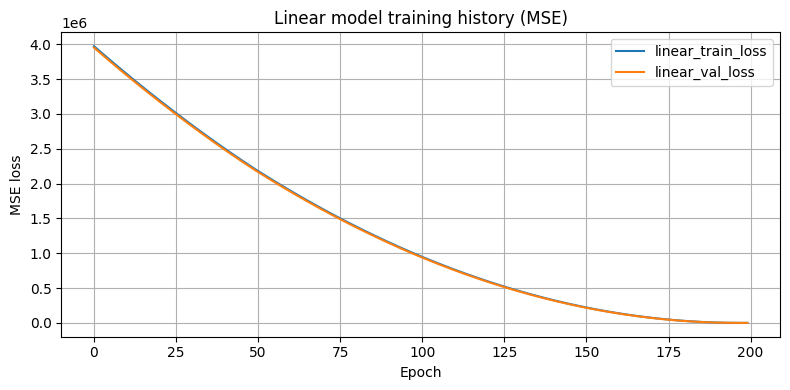

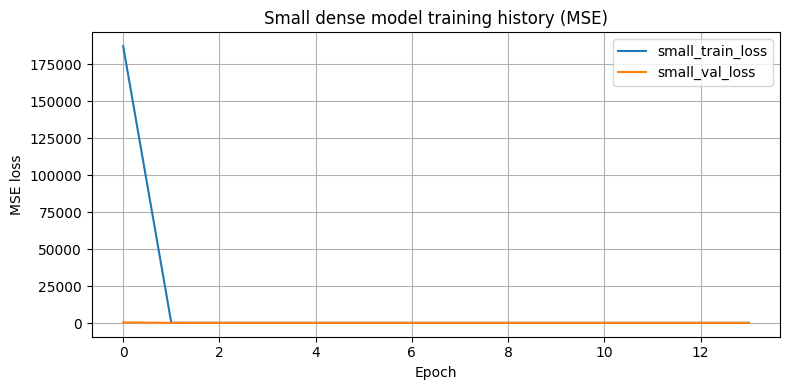

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf

# -----------------------
# Konfigurasi utama program
# -----------------------
# DATA_PATH         : lokasi file dataset CSV
# RANDOM_STATE      : seed supaya eksperimen reproducible
# TEST_SIZE         : persentase data untuk test set
# VALIDATION_SPLIT  : persentase dari train set untuk validasi saat training
# BATCH_SIZE        : ukuran batch untuk training
# MAX_EPOCHS        : jumlah maksimal epoch pelatihan
# PATIENCE          : berapa banyak epoch tanpa peningkatan sebelum early stopping
# SAVE_DIR          : folder tempat menyimpan model & summary
# BEST_MODEL_FILENAME : nama file untuk model terbaik
# VERBOSE           : level output saat training
DATA_PATH = "/content/midterm-regresi-dataset.csv"
RANDOM_STATE = 42
TEST_SIZE = 0.2
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32
MAX_EPOCHS = 200
PATIENCE = 8
SAVE_DIR = "/content"
BEST_MODEL_FILENAME = "best_regression_model.h5"
VERBOSE = 1

# -----------------------
# Menampilkan info TensorFlow & GPU
# -----------------------
# Menampilkan versi TensorFlow dan mengecek apakah GPU tersedia
print("TensorFlow version:", tf.__version__)
gpus = tf.config.list_physical_devices("GPU")
print("GPUs found:", gpus)

# -----------------------
# 1) Memuat data CSV
# -----------------------
# Mengecek apakah file dataset tersedia
# Dataset diasumsikan tanpa header
# Kolom pertama = target (y)
# Kolom lainnya = fitur (X)
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Data file not found at {DATA_PATH}")

df = pd.read_csv(DATA_PATH, header=None)
print("Loaded CSV shape:", df.shape)

y = df.iloc[:, 0].astype(float).values
X = df.iloc[:, 1:].astype(float).values
print("Features shape:", X.shape, "Target shape:", y.shape)

# -----------------------
# 2) Pembersihan data: menangani NaN dan nilai tak hingga
# -----------------------
# Mengubah nilai inf menjadi NaN agar bisa diimputasi
X = np.where(np.isfinite(X), X, np.nan)
y = np.where(np.isfinite(y), y, np.nan)

# Mengisi nilai hilang pada fitur dengan median tiap kolom
imputer = SimpleImputer(strategy="median")
X = imputer.fit_transform(X)
# Jika target memiliki NaN, isi dengan median target
if np.isnan(y).any():
    y = pd.Series(y).fillna(pd.Series(y).median()).values

# -----------------------
# 3) Penanganan outlier dengan metode IQR clipping
# -----------------------
# Menghitung Q1 dan Q3 per fitur, lalu menentukan batas bawah & atas
# Nilai yang keluar dari rentang akan "dipotong" (clipped)
Q1 = np.percentile(X, 25, axis=0)
Q3 = np.percentile(X, 75, axis=0)
IQR = Q3 - Q1
# Menghindari error pada fitur dengan IQR = 0
IQR_safe = np.where(IQR == 0, 1e-9, IQR)
lower = Q1 - 1.5 * IQR_safe
upper = Q3 + 1.5 * IQR_safe
X = np.clip(X, lower, upper)

# -----------------------
# 4) Membagi dataset menjadi train set dan test set
# -----------------------
# Pembagian dilakukan secara acak namun konsisten menggunakan RANDOM_STATE
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape :", X_test.shape, y_test.shape)

# -----------------------
# 5) Normalisasi fitur (standard scaling)
# -----------------------
# Menskalakan fitur ke distribusi standar (mean=0, std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Menyimpan scaler agar dapat digunakan saat inferensi nanti
import joblib
scaler_path = os.path.join(SAVE_DIR, "scaler.save")
joblib.dump(scaler, scaler_path)
print("Saved scaler to:", scaler_path)

# -----------------------
# 6) Membangun dua jenis model
#    - Model linear: hanya 1 layer Dense(1)
#    - Model dense kecil: MLP sederhana untuk perbandingan
# -----------------------
# Kedua model menggunakan optimizer Adam dan loss MSE
n_features = X_train_scaled.shape[1]
tf.random.set_seed(RANDOM_STATE)

def build_linear_model(n_features):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(n_features,)),
        tf.keras.layers.Dense(1, activation="linear", name="linear_output")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse"
    )
    return model

def build_small_dense(n_features):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(n_features,)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(1, activation="linear")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse"
    )
    return model

linear_model = build_linear_model(n_features)
small_model  = build_small_dense(n_features)

# -----------------------
# 7) Melatih kedua model dengan early stopping
# -----------------------
# EarlyStopping memantau val_loss dan menghentikan training jika tidak membaik
# restore_best_weights=True memastikan bobot terbaik dipakai
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)
]

print("\nTraining linear model...")
hist_linear = linear_model.fit(
    X_train_scaled, y_train,
    validation_split=VALIDATION_SPLIT,
    epochs=MAX_EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=VERBOSE
)

print("\nTraining small dense model...")
hist_small = small_model.fit(
    X_train_scaled, y_train,
    validation_split=VALIDATION_SPLIT,
    epochs=MAX_EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=VERBOSE
)

# -----------------------
# 8) Evaluasi model pada data test
# -----------------------
# Menghitung MSE, RMSE, MAE, dan R² untuk membandingkan performa model
def regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}

y_pred_lin = linear_model.predict(X_test_scaled).flatten()
y_pred_small = small_model.predict(X_test_scaled).flatten()

metrics_lin = regression_metrics(y_test, y_pred_lin)
metrics_small = regression_metrics(y_test, y_pred_small)

print("\n=== Linear model metrics on TEST ===")
for k, v in metrics_lin.items():
    print(f"{k}: {v:.4f}")

print("\n=== Small dense model metrics on TEST ===")
for k, v in metrics_small.items():
    print(f"{k}: {v:.4f}")

# -----------------------
# 9) Memilih dan menyimpan model terbaik (berdasarkan RMSE)
# -----------------------
# Model dengan RMSE paling kecil dianggap terbaik dan disimpan sebagai .h5
if metrics_small["RMSE"] < metrics_lin["RMSE"]:
    best_model = small_model
    chosen = "small_dense"
else:
    best_model = linear_model
    chosen = "linear"

best_model_path = os.path.join(SAVE_DIR, BEST_MODEL_FILENAME)
best_model.save(best_model_path)
print(f"\nSaved best model ({chosen}) to: {best_model_path}")

# Menyimpan juga file JSON berisi ringkasan hasil pelatihan
summary = {
    "chosen_model": chosen,
    "metrics_linear": metrics_lin,
    "metrics_small": metrics_small,
    "scaler_path": scaler_path,
    "model_path": best_model_path
}
import json
summary_path = os.path.join(SAVE_DIR, "training_summary.json")
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=2)
print("Saved training summary to:", summary_path)

# -----------------------
# 10) Menampilkan grafik riwayat training untuk kedua model
# -----------------------
# Plot menunjukkan perkembangan loss dan val_loss sepanjang epoch
plt.figure(figsize=(8,4))
plt.plot(hist_linear.history.get("loss", []), label="linear_train_loss")
plt.plot(hist_linear.history.get("val_loss", []), label="linear_val_loss")
plt.title("Linear model training history (MSE)")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Riwayat model small dense
plt.figure(figsize=(8,4))
plt.plot(hist_small.history.get("loss", []), label="small_train_loss")
plt.plot(hist_small.history.get("val_loss", []), label="small_val_loss")
plt.title("Small dense model training history (MSE)")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

=== Linear model metrics on TEST ===
MSE: 88.8273
RMSE: 9.4248
MAE: 6.7161
R2: 0.2536

=== Small dense model metrics on TEST ===
MSE: 115.9769
RMSE: 10.7693
MAE: 8.0195
R2: 0.0255

Model linear memiliki performa jauh lebih baik dari small dense model pada semua metrik. Error-nya lebih rendah dan R²-nya jauh lebih tinggi, sehingga model linear lebih mampu menangkap pola data. Small dense model cenderung underfit dan tidak memberikan manfaat tambahan.